## Capstone: Jonathan

### Modeling Taxi Pickups Time Series - Vector AutoRegression model


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
# Import the autocorrelation function (ACF) plot.
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from statsmodels.tsa.api import VAR


In [ ]:
# Read the saved csv from the earlier notebook and set the index to the date_time column

taxi = pd.read_csv("./data/taxi_2019_clean_2.csv")

In [6]:
# taxi.reset_index()
# taxi.sort_index(inplace=True)

In [ ]:
taxi.head(2)

In [8]:
taxi=taxi.drop(columns='Unnamed: 0')

In [9]:
taxi['pickup_timeofday'].value_counts()

Evening       27253373
Morning       18914461
Afternoon     16690179
Late night    14300799
Name: pickup_timeofday, dtype: int64

In [ ]:
# taxi['pickup_timeofday_digit'] = taxi['pickup_timeofday'].map(lambda x: 1 if x == 'Morning' else x)
# taxi['pickup_timeofday_digit'] = taxi['pickup_timeofday_digit'].map(lambda x: 2 if x == 'Afternoon' else x)
# taxi['pickup_timeofday_digit'] = taxi['pickup_timeofday_digit'].map(lambda x: 3 if x == 'Evening' else x)
# taxi['pickup_timeofday_digit'] = taxi['pickup_timeofday_digit'].map(lambda x: 4 if x == 'Late night' else x)

In [25]:
##seggregating by borough

taxi_manhattan = taxi.loc[taxi.pickup_borough == 'Manhattan',:]
taxi_queens = taxi.loc[taxi.pickup_borough == 'Queens',:]
taxi_brooklyn = taxi.loc[taxi.pickup_borough == 'Brooklyn',:]
taxi_bronx = taxi.loc[taxi.pickup_borough == 'Bronx',:]
taxi_staten_island = taxi.loc[taxi.pickup_borough == 'Staten Island',:]

In [26]:
## Saving to csv
taxi_manhattan.to_csv('./data/taxi_manhattan.csv')
taxi_queens.to_csv('./data/taxi_queens.csv')
taxi_brooklyn.to_csv('./data/taxi_brooklyn.csv')
taxi_bronx.to_csv('./data/taxi_bronx.csv')
taxi_staten_island.to_csv('./data/taxi_staten_island.csv')

In [15]:
taxi['pickup_borough'].value_counts()

Manhattan        70334952
Queens            5256905
Brooklyn           830549
Unknown            627519
Bronx              103920
Staten Island        2629
EWR                  2338
Name: pickup_borough, dtype: int64

In [24]:
##dummy the boroughs

# taxi = pd.get_dummies(taxi, columns=['pickup_borough'])

In [51]:
# taxi.to_csv('./data/taxi_timeseries.csv')

### Correlation and heatmap to confirm realtionship between key variables

<AxesSubplot:>

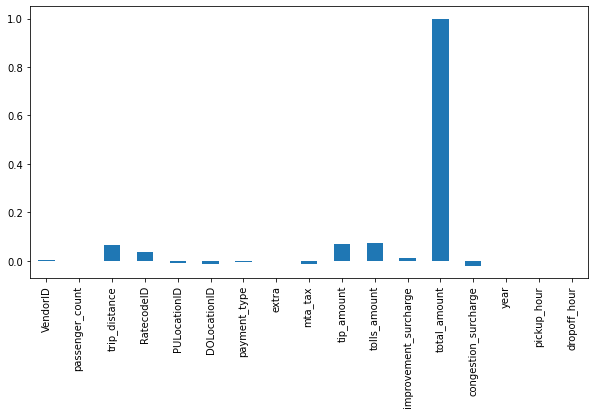

In [30]:
# plt.figure(figsize=(10,5));
# taxi.drop(columns="fare_amount").corrwith(taxi['fare_amount']).plot(kind='bar', sort_columns=True)

Interpretation: pickup zones are positively correlated with drop off zones, congestion surcharge, pickup and drop off hour. In terms of drop off zone, many trips are made within the same borough.
Additionally, congestion/pickup/drop off hours can indicate taxi hails during rush hour. Interestingly enough, trip distance, tip amount and toll amount is negatively correlated.
We can use these for modeling. Since we're doing a Time series, we will only use:
- drop off zones
- congestion surcharge
- pickup/drop off hour
- trip distance
- extra
- toll amount
- all boroughs - except staten island and the bronx
- course pickup zone

In [14]:
taxi.columns

Index(['VendorID', 'dropoff_datetime', 'passenger_count', 'trip_distance',
       'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'month', 'year', 'pickup_day_of_week',
       'dropoff_day_of_week', 'pickup_hour', 'dropoff_hour',
       'pickup_timeofday', 'dropoff_timeofday', 'trip_time', 'pickup_borough',
       'dropoff_borough', 'zone', 'pickup_timeofday_digit'],
      dtype='object')

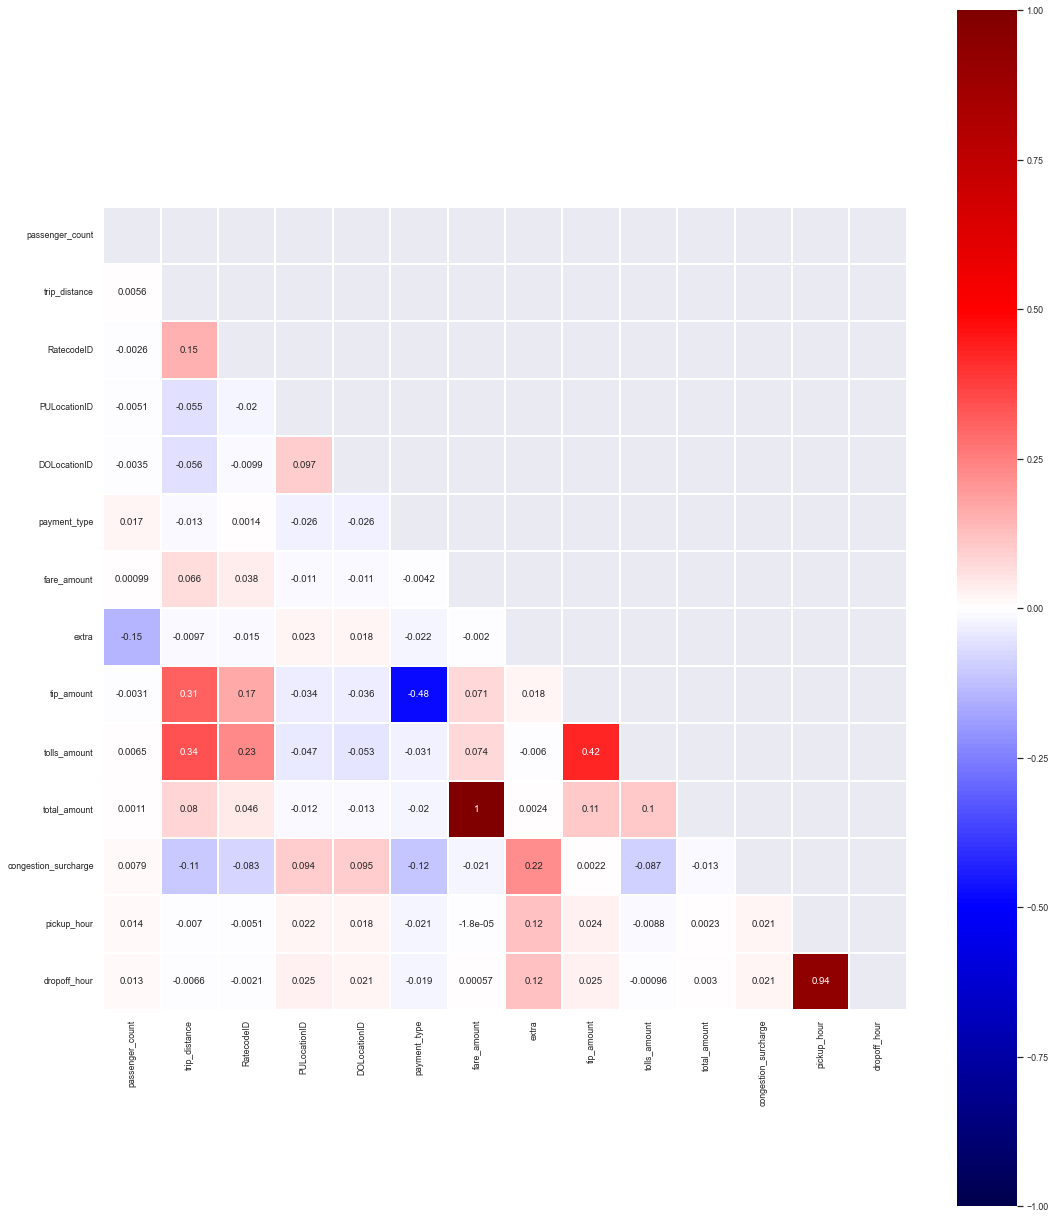

In [32]:
# heatmap showing correlation for relevant columns. 

corr = taxi.drop( columns=["year", "VendorID", "dropoff_datetime", "year", "improvement_surcharge", "mta_tax", "dropoff_borough",
                          'month','pickup_timeofday','pickup_day_of_week', 'dropoff_day_of_week', 'dropoff_datetime',
                          'store_and_fwd_flag','zone']).corr()
plt.figure(figsize=(18,22))

sns.set(font_scale=0.8)

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
sns.heatmap(corr, cmap='seismic', annot=True, square=True,
            vmin = -1, vmax = 1, mask = mask,
            linecolor='white', linewidths=0.1);

In [55]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    legend_list = []
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        legend_list.append(col)
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    # plt.yticks(fontsize=18)
    # plt.xticks(df.index[0::steps], fontsize=12)
    
    plt.legend(legend_list);

In [66]:
# Our dataset is per accident and we converted it to a timeseries by day. 

# # Create new df for modeling which has the columns we need, by month
df_model = taxi.resample("M").sum()[["fare_amount"]]
# df_model['2019']
# # Create new df for modeling which has the columns we need, by week
# df_model_week = taxi.resample("W").sum()[['passenger_count', "fare_amount", "tolls_amount", "extra", "total_amount"]]

# # Create new df for modeling which has the columns we need, by day 
# df_model_day = taxi.resample("D").sum()[['passenger_count', "fare_amount", "tolls_amount", "extra", "total_amount"]]

# # Create new df for modeling which has the columns we need, by 3 hour window

# df_model_3hour = taxi.resample("3H").sum()[['passenger_count', "fare_amount", "tolls_amount", "extra", "total_amount"]]

/var/folders/85/gfsz06392cx1589spz1jvvtc0000gn/T/ipykernel_98302/2621201006.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df_model = df_model['2019']


In [42]:
# taxi.drop( columns=["year", "VendorID", "dropoff_datetime", "passenger_count", "year", "improvement_surcharge", "mta_tax", "dropoff_borough",
#                           'month', 'trip_time','pickup_timeofday', 'dropoff_timeofday','pickup_day_of_week', 'dropoff_day_of_week', 'dropoff_datetime', 'trip_distance',
#                           'store_and_fwd_flag','zone']).columns

NameError: name 'xlab' is not defined

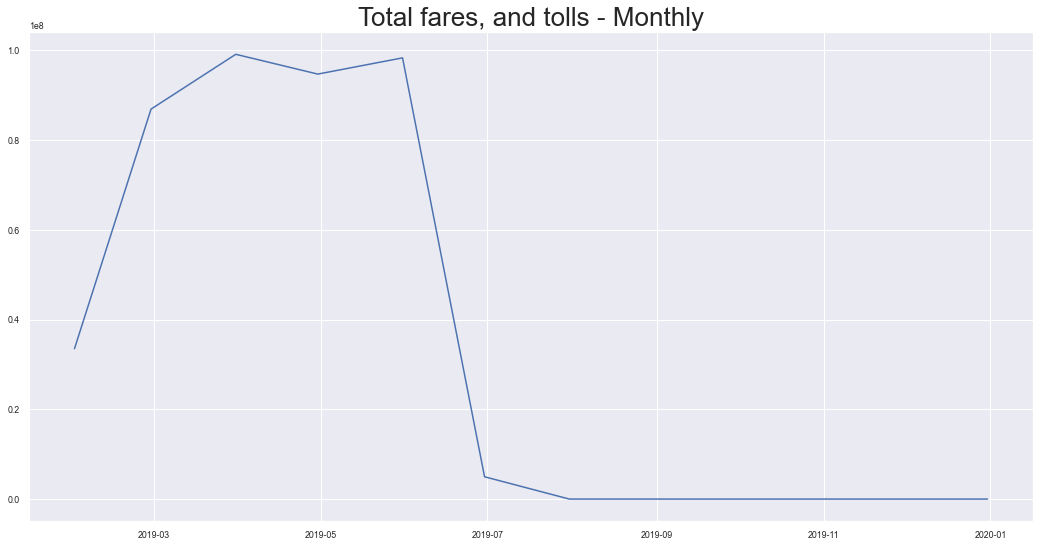

In [67]:
plot_series(df_model, cols=["fare_amount"], 
            title="Total fares, and tolls - Monthly", steps = 12)